# Exploratory Data Analysis (EDA)
## Classification of Heart disease based on cine MRI scan

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Dataset visualization](#handling-missing-values)
3. [Intensity normalization](#feature-distributions)
4. [Orientation normalization](#feature-distributions)


In [1]:
%load_ext autoreload
%autoreload 2

import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import nibabel as nib

import cv2
import skimage.exposure as exposure
from PIL import Image
from IPython.display import Image as DisplayImage

from scipy.ndimage import rotate as rotate_image

from data import data_helper
from data.data_helper import Phase

%matplotlib inline

## Dataset Overview
[Kaggle Link](https://www.kaggle.com/competitions/ai4imaging-hackathon-2024)

Train set: 100 patients, MRI data for two cardiac phases: diastolic and systolic. For each phase, there is one original 3D MRI image and a corresponding segmentation mask file that delineates the region of interest (ROI).\
Test set: 50 subjects without labels

The segmentation mask highlights different anatomical structures of the heart, namely the right ventricle (1), the left ventricle (2), and myocardium (3).

5 classes:
- **Normal subjects (NOR)**: No heart disease
- **Myocardial infarction (MINF)**: blood flow decreases or stops in one of the coronary arteries of the heart, causing infarction (tissue death) to the heart muscle
- **Dilated cardiomyopathy (DCM)**: heart muscle disease that causes the heart chambers (ventricles) to thin and stretch, growing larger. It typically starts in the heart's main pumping chamber (left ventricle)
- **Hypertrophic cardiomyopathy (HCM)**: a condition affecting the left ventricle, the main pumping chamber of the heart. The walls of the left ventricle become thick and stiff
- **Abnormal right ventricle (RV)**: abnormal enlargement of the cardiac muscle surrounding the right ventricle


In [10]:
# define a Colormap for the segmentation masks -> 0:transparent, 1:red, 2:green, 3:blue
roi_cmap = colors.ListedColormap([(0, 0, 0, 0), 'red', 'green', 'blue'])

# show the 3d data as animated gif
def show_gif(img_data, seg=None, mask=None, duration=200, alpha=0.25, save_name=None):
    if mask is not None:
        img_data = img_data * (mask > 0)
    im = [Image.fromarray(img_data[..., i]) for i in range(img_data.shape[-1])]
    if seg is not None:
        for k in range(len(im)):
            seg_colors = roi_cmap(colors.Normalize(0,4)(seg[...,k]), alpha, bytes=True)
            seg_img = Image.fromarray(seg_colors, mode='RGBA')
            im[k] = Image.alpha_composite(im[k].convert('RGBA'), seg_img)

    buffer = io.BytesIO()
    im[0].save(buffer, format='GIF', save_all=True, append_images=im[1:],
               optimize=False, duration=duration, loop=0)
    buffer.seek(0)
    if save_name is not None:
        with open(save_name, "wb") as file:
            file.write(buffer.getbuffer())
    display(DisplayImage(data=buffer.read(), format='gif'))

Patient p0001 (NOR)
{'sys': (168, 224, 14), 'dia': (168, 224, 14), 'sys_seg': (168, 224, 14), 'dia_seg': (168, 224, 14)}
Scaling: (1.78571, 1.78571, 5.0)


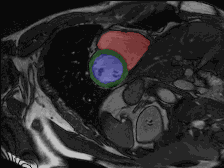

In [11]:
sample_data = data_helper.load_patient(1, load_imgs=True)
data_helper.print_patient_data(sample_data)
show_gif(sample_data[Phase.SYS], seg=sample_data[Phase.SYS_MASK], duration=350)

Red = RV, Green = MC, Blue = LV \
that's not the order in the description...

In [14]:
mask_labels = ['RV', 'MC', 'LV'] # wrong order in description...

In [13]:
train_data = data_helper.load_all_patients('../data/train', load_imgs=True, return_df=True)
train_data.head(0)

Empty DataFrame
Columns: [label, sys, sys_header, sys_seg, sys_seg_header, dia, dia_header, dia_seg, dia_seg_header]
Index: []

Check label balance:

In [7]:
train_data['label'].value_counts()

label
NOR     20
RV      20
MINF    20
HCM     20
DCM     20
Name: count, dtype: int64

Check image shape:

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>,
        <Axes: title={'center': 'z'}>]], dtype=object)

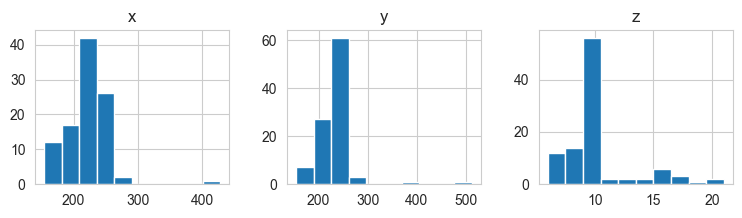

In [54]:
img2shape = lambda img: dict(zip(['x','y','z'], img.shape))

sys_shapes = train_data.apply(lambda row: img2shape(row[Phase.SYS]), axis='columns', result_type='expand')
dia_shapes = train_data.apply(lambda row: img2shape(row[Phase.DIA]), axis='columns', result_type='expand')

assert np.all((sys_shapes - dia_shapes) == 0) # sys and dia img for one patient have same shape

# display(sys_shapes.agg(['mean', 'min', 'max']))
# display(dia_shapes.agg(['mean', 'min', 'max']))
sys_shapes.hist(figsize=(9,2), layout=(1,3))
#dia_shapes.hist(figsize=(9,2), layout=(1,3))

## Let's visualize the data

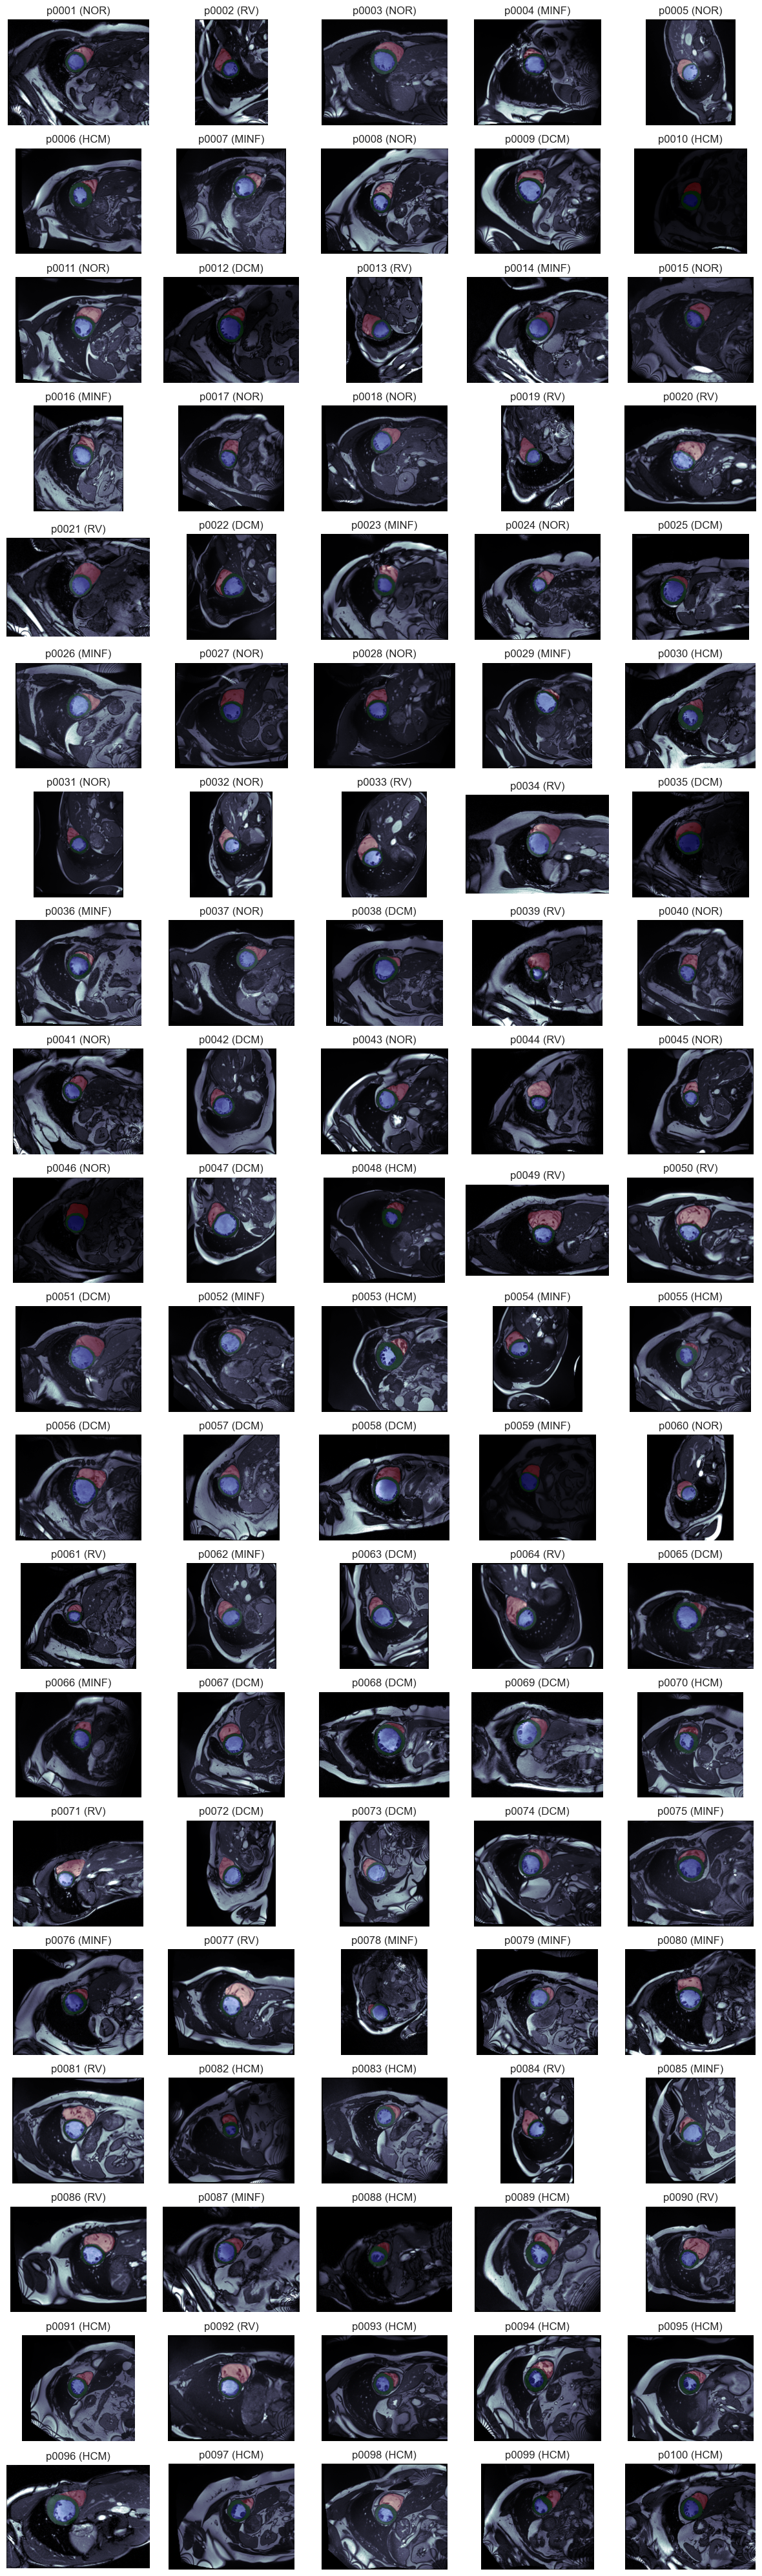

In [56]:
shown_data = train_data#.iloc[:25]
cols = 5
rows = len(shown_data) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 2*rows))
axes = axes.flatten()
for k, subj in shown_data.reset_index().iterrows():
    ax = axes[k]
    depth = subj[Phase.SYS].shape[-1]
    sys = subj[Phase.SYS].copy()
    # sys = sys.clip(0, max(255, np.quantile(sys, 0.99)))
    # sys = sys.clip(0, 750)
    # sys = exposure.equalize_adapthist(sys.astype(np.uint16), clip_limit=0.02)
    sys_seg = subj[Phase.SYS_MASK]
    ax.imshow(sys[..., depth//2], cmap='bone')
    ax.imshow(sys_seg[..., depth//2], alpha=0.2, cmap=roi_cmap)
    ax.set_title(f"{subj['id']} ({subj['label']})")
    ax.axis('off')
plt.tight_layout()
plt.show()

Images have different dimensions, scalings, intensities, rotations... I'm gonna look at some of the prominent examples and try to normalize them \


In [15]:
samples = ['p0001', 'p0002', 'p0010', 'p0012', 'p0025', 'p0059']
sample_data = train_data.loc[samples].reset_index()

## Intensity normalization

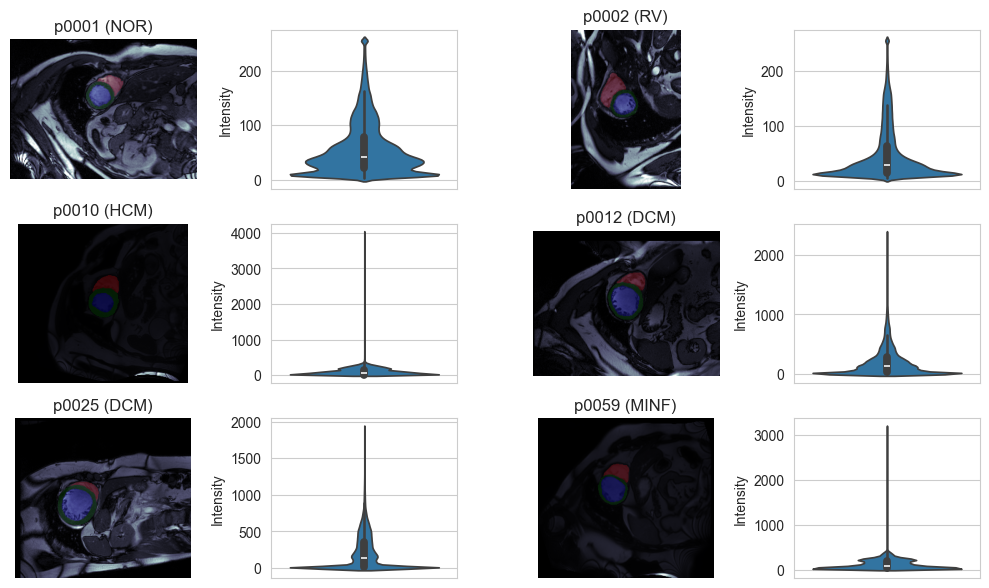

In [69]:
cols = 4
rows = 2 * len(samples) // cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 2*rows))
axes = axes.flatten()
for k, subj in sample_data.iterrows():
    img_ax = axes[2*k]
    sys = subj[Phase.SYS].copy()
    sys_seg = subj[Phase.SYS_MASK]
    depth = sys.shape[-1]
    img_ax.imshow(sys[..., depth//2], cmap='bone')
    img_ax.imshow(sys_seg[..., depth//2], alpha=0.2, cmap=roi_cmap)
    img_ax.set_title(f"{subj['id']} ({subj['label']})")
    img_ax.axis('off')

    hist_ax = axes[2*k+1]
    hist_ax.set_ylabel('Intensity')
    sns.violinplot(sys.reshape(-1), ax=hist_ax)

plt.tight_layout()
plt.show()

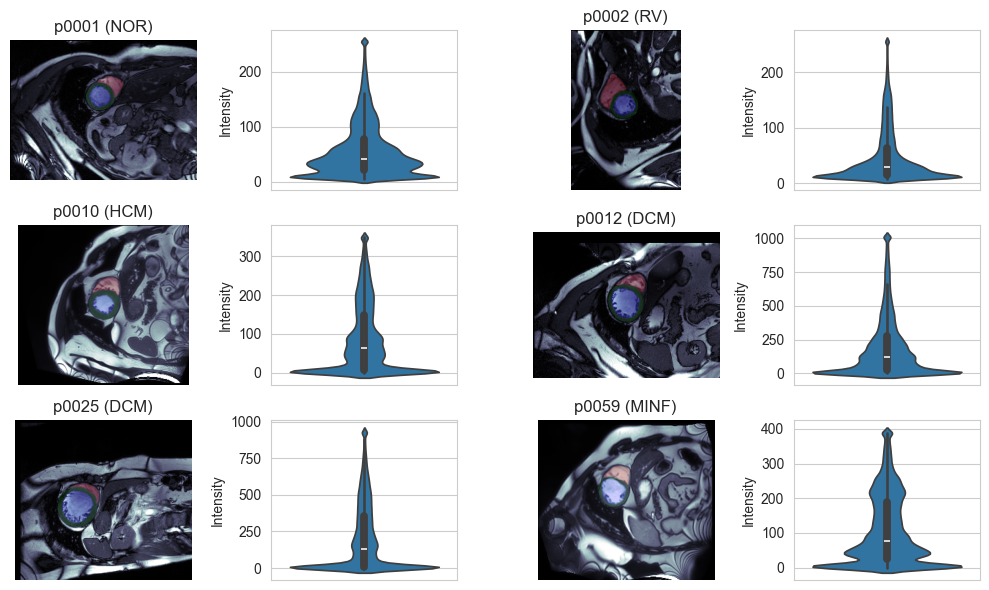

In [70]:
# There are obviously artefacts in the images --> clip extreme values!
cols = 4
rows = 2 * len(samples) // cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 2*rows))
axes = axes.flatten()
for k, subj in sample_data.iterrows():
    img_ax = axes[2*k]
    sys = subj[Phase.SYS].copy()
    sys_seg = subj[Phase.SYS_MASK]
    depth = sys.shape[-1]
    sys = sys.clip(np.percentile(sys, 1), max(255, np.percentile(sys, 99)))
    img_ax.imshow(sys[..., depth//2], cmap='bone')
    img_ax.imshow(sys_seg[..., depth//2], alpha=0.2, cmap=roi_cmap)
    img_ax.set_title(f"{subj['id']} ({subj['label']})")
    img_ax.axis('off')

    hist_ax = axes[2*k+1]
    hist_ax.set_ylabel('Intensity')
    sns.violinplot(sys.reshape(-1), ax=hist_ax)

plt.tight_layout()
plt.show()

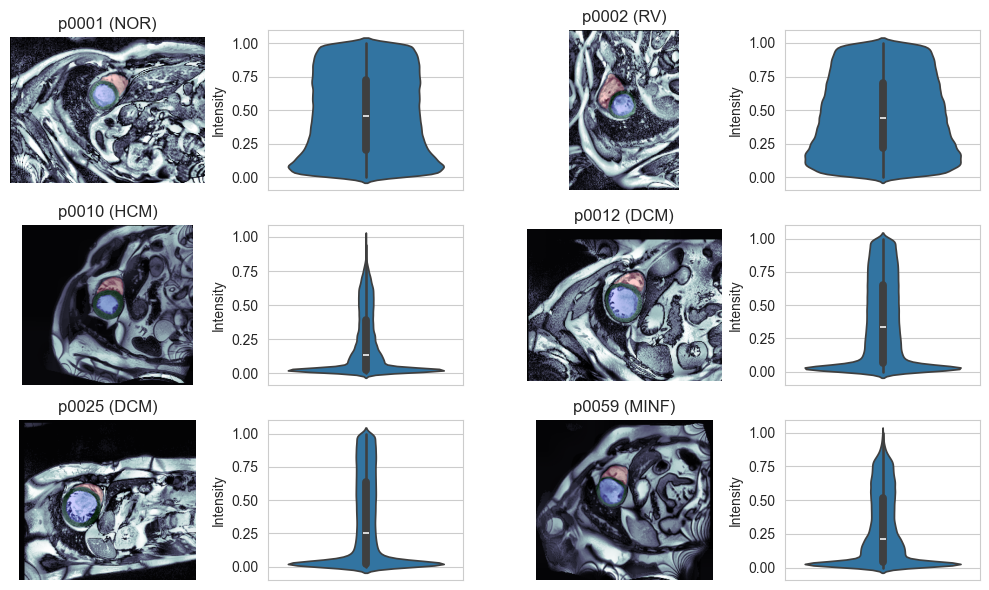

In [40]:
# Now the intensities have to be normalized --> (adaptive) histogram equalization is a good method
cols = 4
rows = 2 * len(samples) // cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 2*rows))
axes = axes.flatten()
for k, subj in sample_data.iterrows():
    img_ax = axes[2*k]
    sys = subj[Phase.SYS].copy()
    sys_seg = subj[Phase.SYS_MASK]
    depth = sys.shape[-1]
    sys = sys.clip(np.percentile(sys, 1), max(255, np.percentile(sys, 99)))
    sys = exposure.equalize_adapthist(sys.astype(np.uint16), clip_limit=0.02)
    img_ax.imshow(sys[..., depth//2], cmap='bone')
    img_ax.imshow(sys_seg[..., depth//2], alpha=0.2, cmap=roi_cmap)
    img_ax.set_title(f"{subj['id']} ({subj['label']})")
    img_ax.axis('off')

    hist_ax = axes[2*k+1]
    hist_ax.set_ylabel('Intensity')
    sns.violinplot(sys.reshape(-1), ax=hist_ax)

plt.tight_layout()
plt.show()

In [16]:
def normalize_intensity(img, clip_limit=0.02):
    img = img.clip(np.percentile(img, 1), np.percentile(img, 99))
    norm_img = 255 * exposure.equalize_adapthist(img.astype(np.uint16), clip_limit=clip_limit)
    return norm_img

train_data_norm = train_data.copy()
train_data_norm[Phase.SYS] = train_data[Phase.SYS].map(normalize_intensity)
train_data_norm[Phase.DIA] = train_data[Phase.DIA].map(normalize_intensity)

Patient Index(['label', 'sys', 'sys_header', 'sys_seg', 'sys_seg_header', 'dia',
       'dia_header', 'dia_seg', 'dia_seg_header'],
      dtype='object') (NOR)
{'sys': (216, 256, 9), 'dia': (216, 256, 9), 'sys_seg': (216, 256, 9), 'dia_seg': (216, 256, 9)}
Scaling: (np.float32(1.3671875), np.float32(1.3671875), np.float32(10.0))


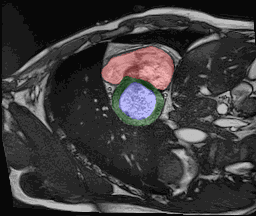

In [110]:
subj = train_data_norm.loc['p0011']
data_helper.print_patient_data(subj)
show_gif(subj[Phase.SYS], seg=subj[Phase.SYS_MASK])

In [17]:
sample_data = train_data_norm.loc[samples].reset_index()

## Normalize orientation

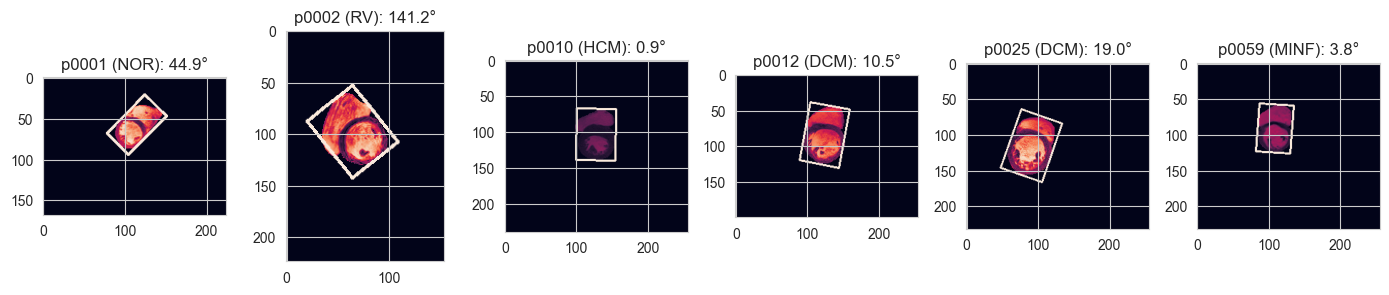

In [39]:
def draw_long_axis_rot(img, return_angle=False):
    img = img.astype(np.uint8)
    # threshold the grayscale image
    ret, thresh = cv2.threshold(img,0,255,0)
    # find outer contour
    cntrs = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]
    # get rotated rectangle from outer contour by fitting an ellipse
    ellipse = cv2.fitEllipse(cntrs[0])
    box = cv2.boxPoints(ellipse)
    box = np.intp(box)
    # draw rotated rectangle on copy of img as result
    result = img.copy()
    cv2.drawContours(result,[box],0,(255,0,0),2)
    if return_angle:
        # get angle from rotated rectangle
        angle = ellipse[-1]
        return result, angle
    else:
        return result

fig, axes = plt.subplots(1, 6, figsize=(14, 3))
axes = axes.flatten()

for k, subj in sample_data.iterrows():
    mask = subj[Phase.SYS_MASK] > 0
    masked_img = subj[Phase.SYS] * mask
    depth = masked_img.shape[-1]
    img_bb, angle = draw_long_axis_rot(masked_img[..., depth//4], return_angle=True)
    axes[k].imshow(img_bb)
    axes[k].set_title(f"{subj['id']} ({subj['label']}): {angle:.1f}°")
plt.tight_layout()
plt.show()

In [18]:
def get_long_axis_rot(mask):
    if mask.ndim == 3:
        mask = mask[..., mask.shape[-1] // 2]
    # cast mask to uint8, all non-zero elements will be treated as 1
    mask = mask.astype(np.uint8)
    # find outer contour
    cntrs = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]
    # get rotated rectangle from outer contour by fitting an ellipse
    ellipse = cv2.fitEllipse(cntrs[0])
    # get angle from rotated rectangle
    angle = ellipse[-1]
    if angle > 90:
        angle = angle - 180
    return angle

def get_long_axis_rot_3d(mask):
    angles = []
    for i in range(mask.shape[-1]):
        mask_slice = mask[..., i]
        if len(np.unique(mask_slice)) < 4:
            continue
        angle = get_long_axis_rot(mask_slice)
        angles.append(angle)
    return np.mean(angles)

Now that we have the rotation of the heart relative to the image orientation, we can correct the orientation

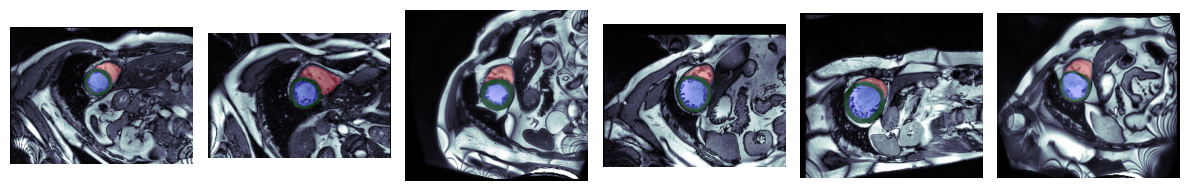

In [124]:
fig, axes = plt.subplots(1, 6, figsize=(12, 3))
axes = axes.flatten()
for k, data in sample_data.iterrows():
    ax = axes[k]
    sys = data[Phase.SYS]
    depth = sys.shape[-1]
    sys_seg = data[Phase.SYS_MASK]
    angle = get_long_axis_rot_3d(sys_seg)
    if angle < 0:
       rot_90 = np.array([[1,-1],[0,1],[2,1]])
       sys = nib.orientations.apply_orientation(sys, rot_90)
       sys_seg = nib.orientations.apply_orientation(sys_seg, rot_90)
    ax.imshow(sys[..., depth//2], cmap='bone')
    ax.imshow(sys_seg[..., depth//2], alpha=0.3, cmap=roi_cmap)
    ax.axis('off')
plt.tight_layout()
plt.show()

Or we can even perform image registration!

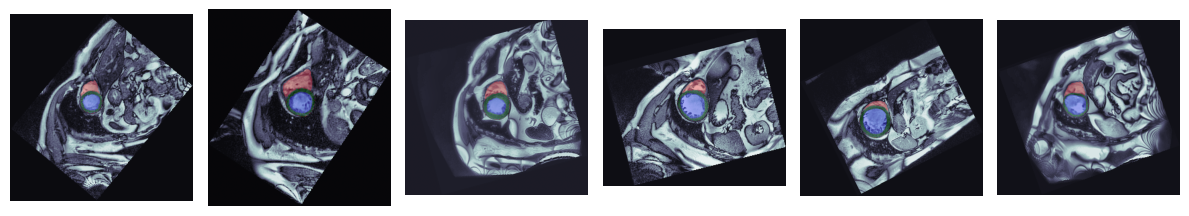

In [19]:
fig, axes = plt.subplots(1, 6, figsize=(12, 3))
axes = axes.flatten()
for k, data in sample_data.iterrows():
    ax = axes[k]
    sys = data[Phase.SYS]
    depth = sys.shape[-1]
    sys_seg = data[Phase.SYS_MASK]
    angle = get_long_axis_rot_3d(sys_seg)
    sys = rotate_image(sys, angle)
    sys_seg = rotate_image(sys_seg, angle)
    ax.imshow(sys[..., depth//2], cmap='bone')
    ax.imshow(sys_seg[..., depth//2], alpha=0.3, cmap=roi_cmap)
    ax.axis('off')
plt.tight_layout()
plt.show()